In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tfd = tfp.distributions
from tqdm import tqdm_notebook as tqdm, trange

In [3]:
with open('hw4_data/nyt_data.txt') as f:
    raw_file = f.readlines()

word_to_id = {}
id_to_word = {}

usa = open('hw4_data/nyt_vocab.dat')
counter = 0
for line in usa:
    word = line.strip()
    word_to_id[word] = counter
    id_to_word[counter] = word
    counter+=1
    
word_list = []
count_list = []

for _,doc in enumerate(raw_file):
    words = doc.strip().split(',')
    w_l = []
    c_l = []
    
    for vocab in words:
        ind, num = vocab.split(':')
        w_l.append(int(ind)-1)
        c_l.append(int(num))
    
    word_list.append(w_l)
    count_list.append(c_l)

In [4]:
len(word_list[0])

163

In [5]:
there_is_0 = False

for l in word_list:
    if min(l) == 0:
        there_is_0 = True
        break
        
print('indices start from 0: {}'.format(there_is_0))

indices start from 0: True


In [6]:
padded_words = tf.keras.preprocessing.sequence.pad_sequences(word_list, padding = 'post', value = 0)
padded_counts = tf.keras.preprocessing.sequence.pad_sequences(count_list, padding = 'post', value = 0)

In [7]:
T = 30
D = len(word_list)
V = len(word_to_id)
d_logits = tf.Variable(tf.initializers.GlorotUniform()((D, T)))
t_logits = tf.Variable(tf.initializers.GlorotUniform()((T, V)))
opt = tf.optimizers.Adam(1e-2)

In [8]:
def calculate_doc_probs(d_logits, t_logits):
    res = tf.math.softmax(d_logits, axis = -1)@tf.math.softmax(t_logits, axis = -1)
    return res

In [9]:
epochs = 1000
loss_records = []
tqdm_range = tqdm(range(epochs))

for e in tqdm_range:
    with tf.GradientTape() as tape:
        prob_mat = calculate_doc_probs(d_logits, t_logits)
        lp = tf.math.log(tf.gather(prob_mat, padded_words, axis=1, batch_dims=1))
        sum_lp = padded_counts * lp
        
        loss = -tf.reduce_mean(sum_lp, axis = 0)
    
    grads = tape.gradient(loss, [d_logits, t_logits])
    opt.apply_gradients(zip(grads, [d_logits, t_logits]))
    loss_records.append(tf.reduce_sum(loss))
    tqdm_range.set_description("{:.2f}".format(tf.reduce_sum(loss).numpy()), refresh = True)

In [10]:
def get_top_words_per_topic(topics, top_k = 20):
    # doesn't matter they are logits or not.. exp is a monotonic function
    top_words = tf.argsort(-topics, axis = -1)[:, :top_k]
    
    for t in range(topics.shape[0]):
        print('* topic {} *'.format(t))
        print([id_to_word[i.numpy()] for i in top_words[t, :]])

In [11]:
get_top_words_per_topic(t_logits, top_k=10)

* topic 0 *
['city', 'local', 'community', 'resident', 'plan', 'area', 'office', 'building', 'live', 'project']
* topic 1 *
['system', 'number', 'program', 'require', 'test', 'problem', 'percent', 'result', 'study', 'standard']
* topic 2 *
['law', 'court', 'case', 'lawyer', 'legal', 'judge', 'rule', 'state', 'issue', 'decision']
* topic 3 *
['company', 'share', 'sell', 'business', 'executive', 'stock', 'buy', 'market', 'sale', 'percent']
* topic 4 *
['school', 'student', 'child', 'class', 'college', 'teacher', 'program', 'attend', 'member', 'education']
* topic 5 *
['team', 'player', 'game', 'play', 'season', 'coach', 'sport', 'baseball', 'guy', 'league']
* topic 6 *
['food', 'serve', 'restaurant', 'taste', 'fresh', 'cook', 'eat', 'add', 'chicken', 'cup']
* topic 7 *
['hit', 'thing', 'put', 'start', 'keep', 'little', 'feel', 'throw', 'pitch', 'hard']
* topic 8 *
['art', 'artist', 'collection', 'museum', 'design', 'photograph', 'exhibition', 'image', 'color', 'painting']
* topic 9 *
['f

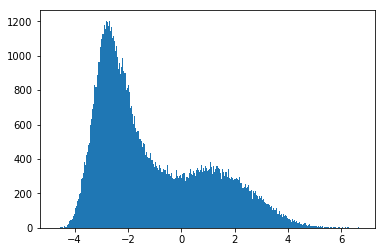

In [12]:
plt.hist(t_logits.numpy().flatten(), bins = 300)
plt.show()

### Original LDA (unsmoothed)

In [13]:
T = 30
D = len(word_list)
V = len(word_to_id)
d_logits = tf.Variable(tf.initializers.GlorotUniform()((D, T)))
t_logits = tf.Variable(tf.initializers.GlorotUniform()((T, V)))
opt = tf.optimizers.Adam(1e-2)
theta_prior = 1.0

d_prior = tfd.Dirichlet(tf.ones((T, )) * theta_prior)

In [14]:
def calculate_doc_probs2(d_probs, t_logits):
    res = d_probs@tf.math.softmax(t_logits, axis = -1)
    return res

In [15]:
epochs = 1000
loss_records = []
tqdm_range = tqdm(range(epochs))

for e in tqdm_range:
    with tf.GradientTape() as tape:
        d_post = tfd.Dirichlet(tf.math.softplus(d_logits))
        d_sample = d_post.sample()
        
        prob_mat = calculate_doc_probs2(d_sample, t_logits)
        lp = tf.math.log(tf.gather(prob_mat, padded_words, axis=1, batch_dims=1))
        sum_lp = padded_counts * lp
        kl = tfd.kl_divergence(d_post, d_prior)
        
        loss = -tf.reduce_sum(tf.reduce_mean(sum_lp, axis = 0)) + tf.reduce_mean(kl)
    
    grads = tape.gradient(loss, [d_logits, t_logits])
    opt.apply_gradients(zip(grads, [d_logits, t_logits]))
    loss_records.append(loss)
    tqdm_range.set_description("{:.2f}".format(loss.numpy()), refresh = True)

In [16]:
tf.reduce_sum(-tf.reduce_mean(sum_lp, axis = 0))

<tf.Tensor: shape=(), dtype=float32, numpy=1042.3682>

In [17]:
get_top_words_per_topic(t_logits, top_k=10)

* topic 0 *
['editor', 'article', 'speak', 'word', 'country', 'religious', 'believe', 'church', 'stand', 'letter']
* topic 1 *
['thing', 'ask', 'tell', 'really', 'feel', 'lot', 'happen', 'put', 'little', 'let']
* topic 2 *
['school', 'student', 'child', 'education', 'class', 'college', 'program', 'teacher', 'group', 'public']
* topic 3 *
['states', 'market', 'company', 'industry', 'trade', 'world', 'american', 'country', 'large', 'big']
* topic 4 *
['family', 'father', 'child', 'mother', 'son', 'woman', 'mrs', 'daughter', 'life', 'old']
* topic 5 *
['job', 'director', 'pay', 'president', 'service', 'employee', 'office', 'hire', 'executive', 'name']
* topic 6 *
['art', 'design', 'artist', 'collection', 'museum', 'color', 'exhibition', 'photograph', 'image', 'display']
* topic 7 *
['room', 'wear', 'house', 'door', 'sit', 'dress', 'front', 'stand', 'floor', 'store']
* topic 8 *
['research', 'study', 'scientist', 'cause', 'expert', 'result', 'problem', 'produce', 'suggest', 'test']
* topic

In [19]:
len(calculate_unique_words(get_top_words_per_topic2(t_logits)))

462

now let's do minibatch training

In [20]:
class sampler_indices:

    def __init__(self, N, batch_size):
        self.batch_size = batch_size
        self.i = 0
        self.N = N
        self.ind = tf.range(self.N)
        self.ind = tf.random.shuffle(self.ind)
        
    def take(self, ):
        i0 = self.i%self.N
        i1 = (self.i + self.batch_size)%self.N
        
        if i0 < i1:

            self.i = i1
            return self.ind[i0:i1]
        
        else:
            x0 = self.ind[i0:]
            x1 = self.ind[:i1]
                
            self.i = i1
            self.ind = tf.random.shuffle(self.ind)
            return np.concatenate((x0, x1), axis = 0)

In [21]:
# build a sampler for document indices
batch_size = 1024
ind_sampler = sampler_indices(padded_words.shape[0], batch_size)

In [22]:
T = 30
D = len(word_list)
V = len(word_to_id)
d_logits = tf.Variable(tf.initializers.GlorotUniform()((D, T)))
t_logits = tf.Variable(tf.initializers.GlorotUniform()((T, V)))
opt = tf.optimizers.Adam(1e-2)
theta_prior = 1.0

d_prior = tfd.Dirichlet(tf.ones((T, )) * theta_prior)

In [23]:
epochs = 1000*(padded_words.shape[0]//batch_size)
tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
loss_records = []

for e in tqdm_range:
    i = ind_sampler.take()
    with tf.GradientTape() as tape:
        w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
        d_logits_i = tf.gather(d_logits, i, axis=0)
        d_post = tfd.Dirichlet(tf.math.softplus(d_logits_i))
        d_sample = d_post.sample()
        
        prob_mat = calculate_doc_probs2(d_sample, t_logits)
        lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
        sum_lp = c * lp
        kl = tfd.kl_divergence(d_post, d_prior)
        
        loss = -tf.reduce_sum(tf.reduce_mean(sum_lp, axis = 0)) + tf.reduce_mean(kl)
    
    grads = tape.gradient(loss, [d_logits, t_logits])
    opt.apply_gradients(zip(grads, [d_logits, t_logits]))
    loss_records.append(loss)
    tqdm_range.set_description("{:.2f}".format(loss.numpy()), refresh = True)

1063.15: 100%|██████████| 8000/8000 [08:12<00:00, 16.24it/s]


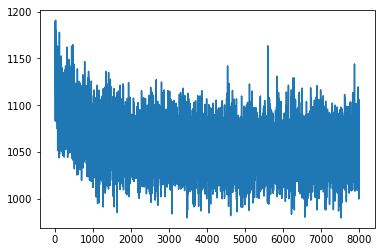

In [24]:
plt.plot(loss_records)

In [25]:
get_top_words_per_topic(t_logits, top_k=10)

* topic 0 *
['police', 'charge', 'man', 'officer', 'crime', 'arrest', 'case', 'yesterday', 'prison', 'kill']
* topic 1 *
['team', 'game', 'season', 'player', 'play', 'coach', 'league', 'baseball', 'start', 'ball']
* topic 2 *
['political', 'campaign', 'vote', 'party', 'election', 'republican', 'candidate', 'leader', 'state', 'democratic']
* topic 3 *
['book', 'editor', 'write', 'article', 'writer', 'life', 'publish', 'read', 'author', 'page']
* topic 4 *
['plan', 'proposal', 'propose', 'bill', 'require', 'approve', 'agreement', 'agree', 'official', 'allow']
* topic 5 *
['meeting', 'news', 'official', 'tell', 'interview', 'speak', 'reporter', 'comment', 'statement', 'ask']
* topic 6 *
['computer', 'company', 'network', 'technology', 'system', 'television', 'service', 'information', 'program', 'site']
* topic 7 *
['mile', 'car', 'hour', 'official', 'travel', 'air', 'water', 'fire', 'driver', 'area']
* topic 8 *
['states', 'country', 'american', 'world', 'international', 'nation', 'europe

In [26]:
def get_top_words_per_topic2(topics, top_k = 20):
    # doesn't matter they are logits or not.. exp is a monotonic function
    top_words = tf.argsort(-topics, axis = -1)[:, :top_k]
    res = []
    for t in range(topics.shape[0]):
        res.append([id_to_word[i.numpy()] for i in top_words[t, :]])
    
    return res

def calculate_unique_words(list_of_list):
    res_set = set({})
    for l in list_of_list:
        res_set = res_set.union(set(l))

    return res_set

In [27]:
len(calculate_unique_words(get_top_words_per_topic2(t_logits)))

469

### Amortized Unsmooth LDA

In [28]:
# we need to engineer an encoder network a bit, because our data is not in a bag of words format

In [51]:
def make_encoder(num_layers, dim, T, V, L, activation = 'tanh', residual = False):
    # we build a keras sequential model with prescribed model
    # first embed into the dimensions
    inputs_w = tf.keras.Input(shape = (L, ))
    inputs_c = tf.keras.Input(shape = (L, ))
    embedded = tf.keras.layers.Embedding(V, dim)(inputs_w)
    x = tf.reduce_sum(embedded * tf.expand_dims(inputs_c, axis = -1), axis = 1) # bow
    
    for l in range(num_layers):
        if residual:
            x = tf.keras.layers.Dense(dim, activation=activation)(x) + x
        else:
            x = tf.keras.layers.Dense(dim, activation=activation)(x)
    
    x = tf.keras.layers.Dense(T, activation = None)(x)
    
    encoder = tf.keras.Model(inputs = [inputs_w, inputs_c], outputs=x)
    return encoder

In [58]:
# build a sampler for document indices
batch_size = 64
ind_sampler = sampler_indices(padded_words.shape[0], batch_size)

T = 30
D = len(word_list)
V = len(word_to_id)
# d_logits = tf.Variable(tf.initializers.GlorotUniform()((D, T)))
t_logits = tf.Variable(tf.initializers.GlorotUniform()((T, V)))
# opt = tf.optimizers.Adam(1e-3, beta_1=0., beta_2 = 0.999, clipvalue=1e-1)
opt = tf.optimizers.RMSprop(1e-3)
theta_prior = 1.0
d_prior = tfd.Dirichlet(tf.ones((T, )) * theta_prior)
d_encoder = make_encoder(3, 64, 30, len(word_to_id), w.shape[1], )
d_encoder.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 883)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 883)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 883, 16)      48192       input_9[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_4 (Tenso [(None, 883, 1)]     0           input_10[0][0]                   
_______________________________________________________________________________________

In [59]:
epochs = 100*(padded_words.shape[0]//batch_size)
tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
loss_records = []

for e in tqdm_range:
    i = ind_sampler.take()
    with tf.GradientTape() as tape:
        w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
        d_logits_i = d_encoder([w, c])
        d_post = tfd.Dirichlet(tf.math.softplus(d_logits_i))
        d_sample = d_post.sample()
        
        prob_mat = calculate_doc_probs2(d_sample, t_logits)
        lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
        sum_lp = c * lp
        kl = tfd.kl_divergence(d_post, d_prior)
        
        loss = -tf.reduce_sum(tf.reduce_mean(sum_lp, axis = 0)) + tf.reduce_mean(kl)
    
    grads = tape.gradient(loss, [t_logits, ] + d_encoder.trainable_variables)
    opt.apply_gradients(zip(grads, [t_logits, ] + d_encoder.trainable_variables))
    loss_records.append(loss)
    tqdm_range.set_description("{:.2f}".format(loss.numpy()), refresh = True)

1128.70: 100%|██████████| 13100/13100 [09:27<00:00, 23.08it/s]


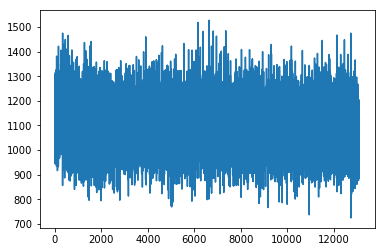

In [60]:
plt.plot(loss_records)
plt.show()

In [61]:
get_top_words_per_topic(t_logits, top_k=10)

* topic 0 *
['tell', 'ask', 'man', 'city', 'group', 'move', 'place', 'school', 'ago', 'name']
* topic 1 *
['official', 'state', 'government', 'issue', 'states', 'political', 'leader', 'public', 'support', 'country']
* topic 2 *
['tell', 'man', 'ask', 'city', 'ago', 'group', 'home', 'name', 'family', 'place']
* topic 3 *
['man', 'home', 'tell', 'life', 'thing', 'name', 'family', 'place', 'old', 'live']
* topic 4 *
['thing', 'home', 'man', 'start', 'tell', 'feel', 'old', 'lot', 'point', 'life']
* topic 5 *
['group', 'states', 'president', 'state', 'public', 'member', 'city', 'country', 'official', 'case']
* topic 6 *
['official', 'state', 'states', 'government', 'member', 'group', 'issue', 'case', 'public', 'plan']
* topic 7 *
['group', 'tell', 'ask', 'city', 'man', 'case', 'problem', 'public', 'ago', 'program']
* topic 8 *
['man', 'tell', 'home', 'life', 'thing', 'old', 'family', 'start', 'child', 'place']
* topic 9 *
['official', 'states', 'state', 'government', 'issue', 'group', 'poli

In [64]:
len(calculate_unique_words(get_top_words_per_topic2(t_logits)))

120

### Smoothed Amortized LDA

In [33]:
?tf.keras.layers.Dropout

In [36]:
def make_dropout_encoder(num_layers, dim, T, V, L, activation = 'relu', dropout = 0.3, residual = False):
    # we build a keras sequential model with prescribed model
    # first embed into the dimensions
    inputs_w = tf.keras.Input(shape = (L, ))
    inputs_c = tf.keras.Input(shape = (L, ))
    embedded = tf.keras.layers.Embedding(V, dim)(inputs_w)
    x = tf.reduce_sum(embedded * tf.expand_dims(inputs_c, axis = -1), axis = 1) # bow
    x = tf.keras.layers.Dropout(dropout)(x)
    
    for l in range(num_layers):
        if residual:
            x = tf.keras.layers.Dropout(dropout)(tf.keras.layers.Dense(dim, activation=activation)(x)) + x
        else:
            x = tf.keras.layers.Dropout(dropout)(tf.keras.layers.Dense(dim, activation=activation)(x))
    
    x = tf.keras.layers.Dense(T, activation = None)(x)
    
    encoder = tf.keras.Model(inputs = [inputs_w, inputs_c], outputs=x)
    return encoder

In [37]:
# build a sampler for document indices
batch_size = 2048
ind_sampler = sampler_indices(padded_words.shape[0], batch_size)

T = 30
D = len(word_list)
V = len(word_to_id)
# d_logits = tf.Variable(tf.initializers.GlorotUniform()((D, T)))
t_logits = tf.Variable(tf.initializers.GlorotUniform()((T, V)))
opt = tf.optimizers.Adam(1e-3)
theta_prior = 1.0
beta_prior = 1.0
d_prior = tfd.Dirichlet(tf.ones((T, )) * theta_prior)
t_prior = tfd.Dirichlet(tf.ones((V, )) * beta_prior)
d_encoder = make_dropout_encoder(3, 64, 30, len(word_to_id), w.shape[1], )
d_encoder.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 883)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 883)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 883, 64)      192768      input_7[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_3 (Tenso [(None, 883, 1)]     0           input_8[0][0]                    
_______________________________________________________________________________________

In [38]:
def calculate_doc_probs3(d_probs, t_probs):
    res = d_probs@t_probs
    return res

In [39]:
epochs = 1000*(padded_words.shape[0]//batch_size)
tqdm_range = trange(epochs, desc='-ELBo: ', position=0, leave=True)
loss_records = []

for e in tqdm_range:
    i = ind_sampler.take()
    with tf.GradientTape() as tape:
        w, c = tf.gather(padded_words, i, axis=0), tf.gather(tf.cast(padded_counts, 'float32'), i, axis=0)
        d_logits_i = d_encoder([w, c], training = True)
        d_post = tfd.Dirichlet(tf.math.softplus(d_logits_i))
        d_sample = d_post.sample()
        
        t_post = tfd.Dirichlet(tf.math.softplus(t_logits))
        t_sample = t_post.sample()
        
        prob_mat = calculate_doc_probs3(d_sample, t_sample)
        lp = tf.math.log(tf.gather(prob_mat, w, axis=1, batch_dims=1))
        sum_lp = c * lp
        kl = tfd.kl_divergence(d_post, d_prior)
        
        loss = -tf.reduce_sum(tf.reduce_mean(sum_lp, axis = 0)) + tf.reduce_mean(kl)
        loss += tf.reduce_sum(tfd.kl_divergence(t_post, t_prior))/batch_size
    
    grads = tape.gradient(loss, [t_logits, ] + d_encoder.trainable_variables)
    opt.apply_gradients(zip(grads, [t_logits, ] + d_encoder.trainable_variables))
    loss_records.append(loss)
    tqdm_range.set_description("-ELBo: {:.2f}".format(loss.numpy()), refresh = True)

-ELBo: 1138.79:  45%|████▌     | 1801/4000 [23:26<28:11,  1.30it/s]

KeyboardInterrupt: 

In [40]:
get_top_words_per_topic(t_logits, top_k=10)

* topic 0 *
['play', 'state', 'company', 'percent', 'official', 'government', 'plan', 'member', 'states', 'open']
* topic 1 *
['group', 'official', 'company', 'member', 'play', 'plan', 'start', 'place', 'states', 'pay']
* topic 2 *
['percent', 'play', 'official', 'man', 'states', 'plan', 'put', 'big', 'group', 'point']
* topic 3 *
['company', 'change', 'point', 'state', 'country', 'group', 'man', 'big', 'put', 'thing']
* topic 4 *
['official', 'percent', 'state', 'group', 'man', 'member', 'plan', 'close', 'report', 'company']
* topic 5 *
['group', 'yesterday', 'play', 'american', 'issue', 'state', 'percent', 'ask', 'man', 'member']
* topic 6 *
['play', 'company', 'man', 'percent', 'country', 'start', 'yesterday', 'move', 'life', 'official']
* topic 7 *
['official', 'percent', 'place', 'put', 'american', 'company', 'start', 'hold', 'states', 'thing']
* topic 8 *
['point', 'company', 'put', 'place', 'thing', 'government', 'play', 'second', 'tell', 'plan']
* topic 9 *
['group', 'percent',

#### To Be Improved: Posterior Collapse in VAE causing topic collapse